In [ ]:
#| include: false

import os
import pandas as pd
import numpy as np
import sqlite3
import toml
from pathlib import Path
import summary_data

config = summary_data.CONFIG
all_runs = summary_data.ALL_RUNS
input_config = summary_data.INPUT_CONFIG

In [4]:
# Join parcel lookup data to parcel files to do some county and district summaries
# Load parcel geography lookup from soundcast db
conn = sqlite3.connect(r'../../../../inputs/db/soundcast_inputs_2023.db')
# df_geog_lookup = pd.read_sql_query("SELECT ParcelID, CountyName, district_name FROM parcel_2023_geography", conn)

# # Land Use Summary
# df_parcels = summary_data.load_landuse('landuse/parcels_urbansim.txt')
# # Merge lookup data to parcels
# df_parcels = df_parcels.merge(df_geog_lookup, left_on='parcelid', right_on='ParcelID', how='left')

# JBLM
The military base Joint Baise Lewis-McChord (JBLM) is treated uniquely in the model.



## Parcel Updates
Adding Military Jobs to Parcels

In [5]:
# Trips generated for JBLM zones

jblm_taz_list = pd.read_sql_query("SELECT * FROM psrc_zones where jblm=1", conn)['taz'].to_list()
jblm_taz_list

[3061, 3070, 3346, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356]

In [172]:
# Military work trips are added as ODs in ixxi_work_trips.h5

def get_external_trips(myh5, NUM_ZONES):

    # Read trip table and get indeces
    # Read table data for each mode and combine into single matrix
    
    # Note: we are assuming ordinal indexing for externals, do not use these to select zone IDs outside of internal zones

    trips = np.zeros((NUM_ZONES, NUM_ZONES), dtype=np.float64)
    for mode in ['sov','hov2','hov3']:
        trips += myh5[mode][:]
    df = pd.DataFrame(
        trips, 
        columns=range(1,NUM_ZONES+1), 
        index=range(1,NUM_ZONES+1)
        )
    
    return df

In [47]:

import h5py

myh5 = h5py.File(f"../../../../outputs/supplemental/external_work_5to6.h5", 'r')
NUM_ZONES = len(myh5['sov'][:])

results_df = pd.DataFrame(
    np.zeros([NUM_ZONES, NUM_ZONES]),
    columns=range(1,NUM_ZONES+1), 
    index=range(1,NUM_ZONES+1)
    )
for tod in config['tod_lookup'].keys():
    myh5 = h5py.File(f"../../../../outputs/supplemental/external_work_{tod}.h5", 'r')
    df = get_external_trips(myh5, NUM_ZONES)
    results_df = results_df + df

# create_ixxi_work_trips.py
### Vehicle trips to/from JBLM zones by origin/destination 

In [157]:
df = pd.DataFrame(results_df[jblm_taz_list].sum(), columns=['trips_to_jblm'])
df_from = pd.DataFrame(results_df.loc[jblm_taz_list].sum(axis=1), columns=['trips_from_jblm'])
df = df.merge(df_from, left_index=True, right_index=True, how='outer')

# Display with commas and as integer
df = df.sort_values(by='trips_from_jblm', ascending=False)
df['trips_total'] = df['trips_to_jblm'] + df['trips_from_jblm']
df.loc['Total'] = df.sum(numeric_only=True)
for col in df.columns:
    df[col] = df[col].apply(lambda x: f"{int(x):,}")

df


,trips_to_jblm,trips_from_jblm,trips_total
3351,"16,557","16,557","33,114"
3070,"10,975","10,975","21,950"
3353,"7,302","7,302","14,604"
3355,"7,162","7,162","14,325"
3349,"6,091","6,091","12,182"
3350,"2,944","2,944","5,889"
3354,"2,735","2,735","5,470"
3352,"1,561","1,561","3,123"
3346,"1,180","1,180","2,361"
3356,984,984,"1,969"


In [ ]:
# Total trips from external stations
results_df[3700:].sum().sum()

np.float64(83916.24721269442)

In [166]:
# Total trips to external stations
results_df.loc[3700:].sum().sum()

np.float64(83927.1946450092)

# Daysim Vehicle Trips to/from JBLM

In [67]:
trips_df = pd.read_csv(r'../../../../outputs/daysim/_trip.tsv',
                    sep='\t')

In [75]:
from_trips = trips_df[(trips_df['otaz'].isin(jblm_taz_list)) & (trips_df['dorp']==1) & (trips_df['mode'].isin([3,4,5]))]
to_trips = trips_df[(trips_df['dtaz'].isin(jblm_taz_list)) & (trips_df['dorp']==1) & (trips_df['mode'].isin([3,4,5]))]
print(f"Total Daysim trips from JBLM zones: {from_trips['trexpfac'].sum()}")
print(f"Total Daysim trips to JBLM zones: {to_trips['trexpfac'].sum()}")

Total Daysim trips from JBLM zones: 10250
Total Daysim trips to JBLM zones: 10256


#### Daysim trips from JBLM by purpose
Since employment is removed from JBLM, we expect Daysim to not predict work trips (opurp==1) inside JBLM

In [77]:
# 
pd.DataFrame([from_trips['opurp'].value_counts(),
              to_trips['dpurp'].value_counts()]).T.fillna(0).astype(int).rename(
    columns={'count': 'from_JBLM', 'count': 'to_JBLM'}
              )

,to_JBLM,to_JBLM
0,9625,9637
3,320,315
7,202,201
4,53,52
6,40,40
2,10,11


## Daysim Results for JBLM Residents

In [81]:
# Residents in JBLM zones
hh_df = pd.read_csv(r'../../../../outputs/daysim/_household.tsv',
                    sep='\t')
person_df = pd.read_csv(r'../../../../outputs/daysim/_person.tsv',
                    sep='\t')
person_df = person_df.merge(hh_df[['hhtaz','hhno']], on='hhno', how='left')
jblm_person_df = person_df[person_df['hhtaz'].isin(jblm_taz_list)].copy()

print(f"Total Daysim persons in JBLM zones: {jblm_person_df['pno'].nunique()}")

Total Daysim persons in JBLM zones: 8


### Persons with Job Locations in JBLM Zones
Should be minimal because employment in JBLM zones is zeroed out in create_ixxi_work_trips.py 

In [82]:
jblm_person_df = person_df[person_df['hhtaz'].isin(jblm_taz_list)].copy()
jblm_person_df['job_in_jblm'] = "Not in JBLM"
jblm_person_df.loc[jblm_person_df['pwtaz'].isin(jblm_taz_list), 'job_in_jblm']  = "In JBLM"

pd.DataFrame(jblm_person_df['job_in_jblm'].value_counts())

,count
job_in_jblm,
Not in JBLM,16305
In JBLM,324


### Age Distribution
Of synthetic population within JBLM zones

Text(0.5, 1.0, 'Distribution of Age in JBLM Zones')

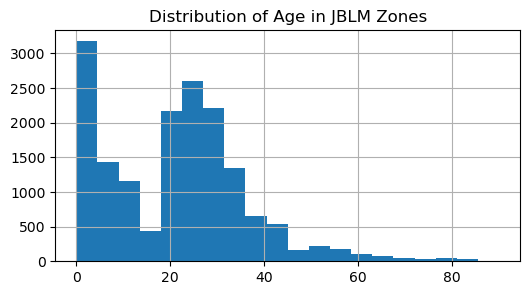

In [83]:
# Plot distribution of pagey 
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
jblm_person_df['pagey'].hist(bins=20)
plt.title('Distribution of Age in JBLM Zones')

#### Daysim IXXI File

This file in generated in create_ixxi_work_trips.py and specifies what share of each zone to exclude from DaySim Work Location model

Within JBLM area, Jobs_XIFrac should be 1 because we are using the exogenous data for work flows in these zones
If Jobs_XIFrac == 1 then Daysim will not send workers to jobs in these zones

Worker_IXFrac is not equal to 1 because workers in the synthetic population for these areas 
may have jobs outside the base area (family members of enlisted)


In [84]:
# Load ixxi fractions file and set column names

df_ixxi = pd.read_csv(r"../../../../outputs/landuse/psrc_worker_ixxifractions.dat", sep='\t', header=None)
df_ixxi.columns = ['taz', 'Worker_IXFrac', 'Jobs_XIFrac']
df_ixxi[df_ixxi['taz'].isin(jblm_taz_list)]

,taz,Worker_IXFrac,Jobs_XIFrac
3060,3061,0.011,1.0
3069,3070,1.000,1.0
3345,3346,0.000,1.0
3347,3348,0.010,1.0
3348,3349,0.006,1.0
3349,3350,0.083,1.0
3350,3351,1.000,1.0
3351,3352,0.024,1.0
3352,3353,0.965,1.0
3353,3354,0.000,1.0


# Network Counts

In [ ]:
# Kris to add 





# Parcels Jobs

In [118]:
df_parcel_input = pd.read_csv('../../../../inputs/scenario/landuse/parcels_urbansim.txt', sep=' ')
df_parcel_output = pd.read_csv('../../../../outputs/landuse/parcels_urbansim.txt', sep=' ')

parcels_military = pd.read_sql(
        "SELECT * FROM enlisted_personnel WHERE year=="
        + input_config["model_year"],
        con=conn,
    )

In [129]:
parcels_military = parcels_military.groupby('Zone').sum().reset_index()
parcels_military = parcels_military[['Zone', 'military_jobs']]
parcels_military.rename(columns={'military_jobs': 'military_jobs_target'}, inplace=True)

Compare Military Jobs by Zone before create_ixxi_work_trips.py and afterwards

JBLM Zones should have 0 total employment in output file

In [135]:
df_before = df_parcel_input[df_parcel_input['taz_p'].isin(parcels_military.Zone)].groupby('taz_p')['emptot_p'].sum().reset_index().sort_values(by='emptot_p', ascending=False)
df_after = df_parcel_output[df_parcel_output['taz_p'].isin(parcels_military.Zone)].groupby('taz_p')['emptot_p'].sum().reset_index().sort_values(by='emptot_p', ascending=False)

df = df_before.merge(df_after, left_on='taz_p', right_on='taz_p', how='outer')
df = df.rename(columns={'taz_p': 'taz', 'emptot_p_x': 'emptot_p_input', 'emptot_p_y': 'emptot_p_output'})

df = df.merge(parcels_military, left_on='taz', right_on='Zone', how='outer')
df.drop(columns=['Zone'], inplace=True)

# set index to taz
df = df.set_index('taz')
df.loc['Total'] = df.sum(numeric_only=True)
# Show results with commas and as integer
for col in df.columns:
    df[col] = df[col].apply(lambda x: f"{int(x):,}")

# Show JBLM Zones
df[df.index.isin(jblm_taz_list)][['emptot_p_input','emptot_p_output']]


,emptot_p_input,emptot_p_output
taz,,
3061,167,0
3070,"2,612",0
3348,"1,176",0
3349,540,0
3350,183,0
3351,135,0
3353,304,0
3355,"1,319",0


Other military zones should have emptot_p equal to the target number of military jobs to be added

In [136]:
df[~df.index.isin(jblm_taz_list)]

,emptot_p_input,emptot_p_output,military_jobs_target
taz,,,
105,"1,535","1,535",75
331,364,364,204
390,"1,035","1,035",300
2255,976,976,"4,704"
3496,896,896,"1,330"
3508,"1,759","1,759",57
3518,"3,034","3,034","1,716"
3626,"14,893","14,893","4,784"
Total,"30,928","24,492","49,302"


### Non-Work

Trip Generation

In [232]:
# Productions from external zones
df = pd.read_csv('../../../../outputs/supplemental/7_balance_trip_ends.csv')
prods = int(df.loc[df['taz'] >= 3733, 'hsppro'].sum())
print(f"Total productions from external zones: {prods:,}")


Total productions from external zones: 75,111


In [214]:
# Trip Generation
# for non-work trips
df = pd.read_csv('../../../../outputs/supplemental/7_balance_trip_ends.csv')
df = df[df['taz'].isin(jblm_taz_list)][['hsppro']].sort_values(by='hsppro', ascending=False)
df.loc['Total'] = df.sum(numeric_only=True)
# show with commas and as integer
df['hsppro'] = df['hsppro'].apply(lambda x: f"{int(x):,}")
# Create total row

df

,hsppro
3069,"1,392"
3350,"1,110"
3349,"1,031"
3347,974
3351,832
3348,643
3060,426
3354,28
3352,18
3355,10


Trip Tables

In [183]:
myh5 = h5py.File("../../../../outputs/supplemental/external_non_work.h5", 'r')
non_work_df = get_external_trips(myh5, NUM_ZONES)

In [212]:
total_non_work_trips = int(non_work_df.sum().sum())
print(f"Total non-work trips in region: {total_non_work_trips:,}")

# Non work trips to/from externals
non_work_df_ext = int(non_work_df.loc[3700:].sum().sum())
# non_work_df.loc[3700:].sum().sum()
print(f"External -> Internal non-work trips in region: {non_work_df_ext:,}")

# Non work trips to/from JBLM
non_work_df_ext = int(non_work_df[3700:].sum().sum())
# non_work_df.loc[3700:].sum().sum()
print(f"Internal -> External non-work trips in region: {non_work_df_ext:,}")

# Internal -> Internal non-work trips
non_work_df_int = int(non_work_df.loc[1:3700,1:3700].sum().sum())
print(f"Internal -> Internal non-work trips in region: {non_work_df_int:,}")


Total non-work trips in region: 157,943
External -> Internal non-work trips in region: 78,972
Internal -> External non-work trips in region: 78,971
Internal -> Internal non-work trips in region: 0


In [233]:

# Vehicle trips to/from JBLM zones
df = pd.DataFrame(non_work_df[jblm_taz_list].sum(), columns=['trips_to_jblm'])
df_from = pd.DataFrame(non_work_df.loc[jblm_taz_list].sum(axis=1), columns=['trips_from_jblm'])
df = df.merge(df_from, left_index=True, right_index=True, how='outer')

# Display with commas and as integer
df = df.sort_values(by='trips_from_jblm', ascending=False)
df['trips_total'] = df['trips_to_jblm'] + df['trips_from_jblm']
df.loc['Total'] = df.sum(numeric_only=True)
for col in df.columns:
    df[col] = df[col].apply(lambda x: f"{int(x):,}")

df

,trips_to_jblm,trips_from_jblm,trips_total
3061,0,0,1
3348,0,0,0
3346,0,0,0
3352,0,0,0
3349,0,0,0
3351,0,0,0
3350,0,0,0
3070,0,0,0
3355,0,0,0
3353,0,0,0


In [36]:
jblm_trips = pd.read_sql_query("SELECT * FROM jblm_trips", conn)

In [37]:
jblm_trips['year']

0       2014
1       2014
2       2014
3       2014
4       2014
        ... 
4831    2014
4832    2014
4833    2014
4834    2014
4835    2014
Name: year, Length: 4836, dtype: int64

In [38]:
df = jblm_trips.groupby('origin_zone').sum().reset_index().sort_values('trips', ascending=False)

In [39]:
df[df['origin_zone'].isin(jblm_taz_list)][['origin_zone','trips']]

,origin_zone,trips
270,3351,12172
198,3070,11029
272,3353,6265
268,3349,4080
274,3355,3947
273,3354,3808
269,3350,1677
271,3352,1339
189,3061,1080
266,3346,786


In [40]:
ext_df = pd.read_sql_query("SELECT * FROM external_trip_distribution", conn)
# df = ext_df.groupby('PSRC_TAZ').sum().reset_index().sort_values('Total_IE', ascending=False)
# df

In [41]:
ext_df[ext_df['PSRC_TAZ']  == 3351]

,Unnamed: 0,PSRC_TAZ,External_Station,Total_IE,Total_EI,SOV_Per_IE,SOV_Per_EI,HOV2_Per_IE,HOV2_Per_EI,HOV3_Per_IE,HOV3_Per_EI,SOV_Veh_IE,SOV_Veh_EI,HOV2_Veh_IE,HOV2_Veh_EI,HOV3_Veh_IE,HOV3_Veh_EI
173213,15438,3351,3070,2870.0,2870.0,2135.280,2135.280,346.9830,346.9830,186.8370,186.8370,2306.102400,2306.102400,187.370820,187.370820,57.652560,57.652560
173214,15439,3351,3346,16.0,25.0,11.904,18.600,1.9344,3.0225,1.0416,1.6275,12.856320,20.088000,1.044576,1.632150,0.321408,0.502200
173215,15440,3351,3348,2.0,3.0,1.488,2.232,0.2418,0.3627,0.1302,0.1953,1.607040,2.410560,0.130572,0.195858,0.040176,0.060264
173216,15441,3351,3349,82.0,123.0,61.008,91.512,9.9138,14.8707,5.3382,8.0073,65.888640,98.832960,5.353452,8.030178,1.647216,2.470824
173217,15442,3351,3350,68.0,169.0,50.592,125.736,8.2212,20.4321,4.4268,11.0019,54.639360,135.794880,4.439448,11.033334,1.365984,3.394872
173218,15443,3351,3733,24.0,4.0,17.856,2.976,2.9016,0.4836,1.5624,0.2604,15.641856,2.606976,1.270901,0.211817,0.391046,0.065174
173219,15444,3351,3735,7.0,0.0,5.208,0.000,0.8463,0.0000,0.4557,0.0000,5.208000,0.000000,0.423150,0.000000,0.130200,0.000000
173220,15445,3351,3739,5.0,0.0,3.720,0.000,0.6045,0.0000,0.3255,0.0000,3.720000,0.000000,0.302250,0.000000,0.093000,0.000000
173221,15446,3351,3744,7.0,0.0,5.208,0.000,0.8463,0.0000,0.4557,0.0000,5.208000,0.000000,0.423150,0.000000,0.130200,0.000000
173222,15447,3351,3748,3.0,0.0,2.232,0.000,0.3627,0.0000,0.1953,0.0000,2.232000,0.000000,0.181350,0.000000,0.055800,0.000000


In [42]:
ext_df

,Unnamed: 0,PSRC_TAZ,External_Station,Total_IE,Total_EI,SOV_Per_IE,SOV_Per_EI,HOV2_Per_IE,HOV2_Per_EI,HOV3_Per_IE,HOV3_Per_EI,SOV_Veh_IE,SOV_Veh_EI,HOV2_Veh_IE,HOV2_Veh_EI,HOV3_Veh_IE,HOV3_Veh_EI
0,2,2203,3740,0.492252,0.0,0.393801,0.000,0.05907,0.0000,0.03938,0.0000,0.393801,0.00000,0.029535,0.000000,0.011251,0.000000
1,22,189,3740,0.492252,0.0,0.393801,0.000,0.05907,0.0000,0.03938,0.0000,0.393801,0.00000,0.029535,0.000000,0.011251,0.000000
2,23,1937,3740,0.492252,0.0,0.393801,0.000,0.05907,0.0000,0.03938,0.0000,0.393801,0.00000,0.029535,0.000000,0.011251,0.000000
3,68,2428,3740,0.492252,0.0,0.393801,0.000,0.05907,0.0000,0.03938,0.0000,0.393801,0.00000,0.029535,0.000000,0.011251,0.000000
4,135,343,3740,0.492252,0.0,0.393801,0.000,0.05907,0.0000,0.03938,0.0000,0.393801,0.00000,0.029535,0.000000,0.011251,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173766,17517,3733,3351,2876.000000,3325.0,2139.744000,2473.800,347.70840,401.9925,187.22760,216.4575,2310.923520,2671.70400,187.762536,217.075950,57.773088,66.792600
173767,17518,3733,3352,477.000000,490.0,354.888000,364.560,57.66930,59.2410,31.05270,31.8990,383.279040,393.72480,31.141422,31.990140,9.581976,9.843120
173768,17519,3733,3353,2192.000000,2255.0,1630.848000,1677.720,265.01280,272.6295,142.69920,146.8005,1761.315840,1811.93760,143.106912,147.219930,44.032896,45.298440
173769,17520,3733,3354,2173.000000,1863.0,1616.712000,1386.072,262.71570,225.2367,141.46230,121.2813,1746.048960,1496.95776,141.866478,121.627818,43.651224,37.423944


In [43]:
# ext_df = pd.read_sql_query("SELECT * FROM external_trip_distribution", conn)
# df = ext_df.groupby('PSRC_TAZ').sum().reset_index().sort_values('Total_EI', ascending=False)

In [44]:
ext_df['PSRC_TAZ'] == 

SyntaxError: invalid syntax (3184092538.py, line 1)